In [1]:
import pandas as pd
from data_cleaning.calc_fpoints import calc_fpoints_batter, calc_fpoints_pitcher
from data_cleaning.combine_dfs import combine_metrics_stats, pitch_combine_metrics_stats
from plotting.plots import plot_top_x_corr
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE, SelectKBest, f_regression, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
import warnings

import lime

import lime.lime_tabular
import unidecode


In [2]:
# Reading in data and calculating fantasy points
# Minimum PA of 50 for both datasets
pitcher_data = pd.read_csv("data/pitcher_stats_base.csv")
pitcher_fpoints = calc_fpoints_pitcher(pitcher_data, output = False)
pitcher_fpoints.head()


Name  year  age     IP    H    K  BB  ER  S   W   L  Hold  \
0   Colon, Bartolo  2015   42  194.2  217  136  24  90  0  14  13     0   
1  Hawkins, LaTroy  2015   42   38.2   44   34   7  14  3   3   1     7   
2      Wolf, Randy  2015   38   34.2   46   28  15  24  0   0   5     1   
3   Marquis, Jason  2015   36   47.1   64   37  14  34  0   3   4     0   
4    Burnett, A.J.  2015   38  164.0  174  143  49  58  0   9   7     0   

   Fpoints  Fpoints_IP  
0    297.6    1.532441  
1     69.6    1.821990  
2     21.6    0.631579  
3     32.3    0.685775  
4    296.0    1.804878

In [3]:
name_split = pitcher_fpoints['Name'].str.split(', ', expand=True)
# Combine first and last names in the desired format
# Replace accented letters in the Name column
pitcher_fpoints['Name'] = name_split[1] + ' ' + name_split[0]
pitcher_fpoints['Name'] = pitcher_fpoints['Name'].apply(unidecode.unidecode)

In [4]:

all_fpoints_24 = pitcher_fpoints[pitcher_fpoints['year'] == 2024][["Name", "Fpoints_IP"]]
all_fpoints_24.head()

Name  Fpoints_IP
5432  Justin Verlander    1.213097
5433     Kenley Jansen    2.335793
5434      Jesse Chavez    1.922345
5435    Charlie Morton    1.752271
5436      Max Scherzer    1.886311

In [5]:
pitcher_metrics = pd.read_csv("data/pitcher_metrics.csv")
pitcher_combined = pitch_combine_metrics_stats(pitcher_fpoints, pitcher_metrics, save = False)
pitcher_combined.head()

Name  Fpoints_IP  year  age  k_percent  bb_percent    xba   xslg  \
0   Bartolo Colon    1.692469  2016   43       16.7         2.9  0.268  0.427   
1    Jason Grilli    2.169492  2016   39       32.1         7.1  0.221  0.359   
2  Joaquin Benoit    2.187500  2016   38       24.8         9.1  0.194  0.328   
3    Matt Belisle    2.217391  2016   36       16.8        10.1  0.238  0.320   
4     CC Sabathia    1.655134  2016   35       18.9         6.9  0.253  0.378   

    woba  xwoba  ...  breaking_avg_break_z_induced  breaking_avg_break  \
0  0.316  0.314  ...                           3.3                 6.5   
1  0.269  0.275  ...                          -3.0                12.7   
2  0.243  0.271  ...                           4.8                 6.5   
3  0.306  0.297  ...                           0.6                 8.8   
4  0.343  0.304  ...                          -0.1                11.8   

   breaking_range_speed  n_offspeed_formatted  offspeed_avg_speed  \
0                   1.8                   7.4                82.6   
1                   1.2                   0.2                86.5   
2                   1.8                  34.4                84.7   
3                   5.0                   3.1                86.4   
4                   1.5                  14.0                83.9   

   offspeed_avg_spin  offspeed_avg_break_x  offspeed_avg_break_z  \
0             1727.0                 -13.2                 -32.0   
1             2257.0                 -15.3                 -26.5   
2             1434.0                 -12.4                 -36.0   
3             1838.0                  -5.9                 -33.6   
4             1950.0                  11.1                 -30.1   

   offspeed_avg_break_z_induced  offspeed_avg_break  
0                           9.0                16.4  
1                          10.8                18.7  
2                           2.8                13.1  
3                           3.7                 7.9  
4                           9.4                15.0  

[5 rows x 64 columns]

In [6]:
pitcher_combined.shape

(3843, 64)

## EDA

In [7]:
pitcher_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3843 entries, 0 to 3842
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          3843 non-null   object 
 1   Fpoints_IP                    3843 non-null   float64
 2   year                          3843 non-null   int64  
 3   age                           3843 non-null   int64  
 4   k_percent                     3843 non-null   float64
 5   bb_percent                    3843 non-null   float64
 6   xba                           3843 non-null   float64
 7   xslg                          3843 non-null   float64
 8   woba                          3843 non-null   float64
 9   xwoba                         3843 non-null   float64
 10  xobp                          3843 non-null   float64
 11  xiso                          3843 non-null   float64
 12  xwobacon                      3843 non-null   float64
 13  xba

In [8]:
missing_values = pitcher_combined.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

arm_angle                       2108
n_breaking_formatted              33
breaking_avg_speed                33
breaking_avg_spin                 33
breaking_avg_break_x              33
breaking_avg_break_z              33
breaking_avg_break_z_induced      33
breaking_avg_break                33
breaking_range_speed              38
n_offspeed_formatted             467
offspeed_avg_speed               467
offspeed_avg_spin                470
offspeed_avg_break_x             467
offspeed_avg_break_z             467
offspeed_avg_break_z_induced     467
offspeed_avg_break               467
dtype: int64

In [9]:
# Need to remove arm_angle. Will impute missing individual pitch data. 
# Year is also not good for prediction since we dont have any 2024 data - going to keep this for now to generate some average stats for each year
pitcher_combined = pitcher_combined.drop(columns = ['arm_angle'])

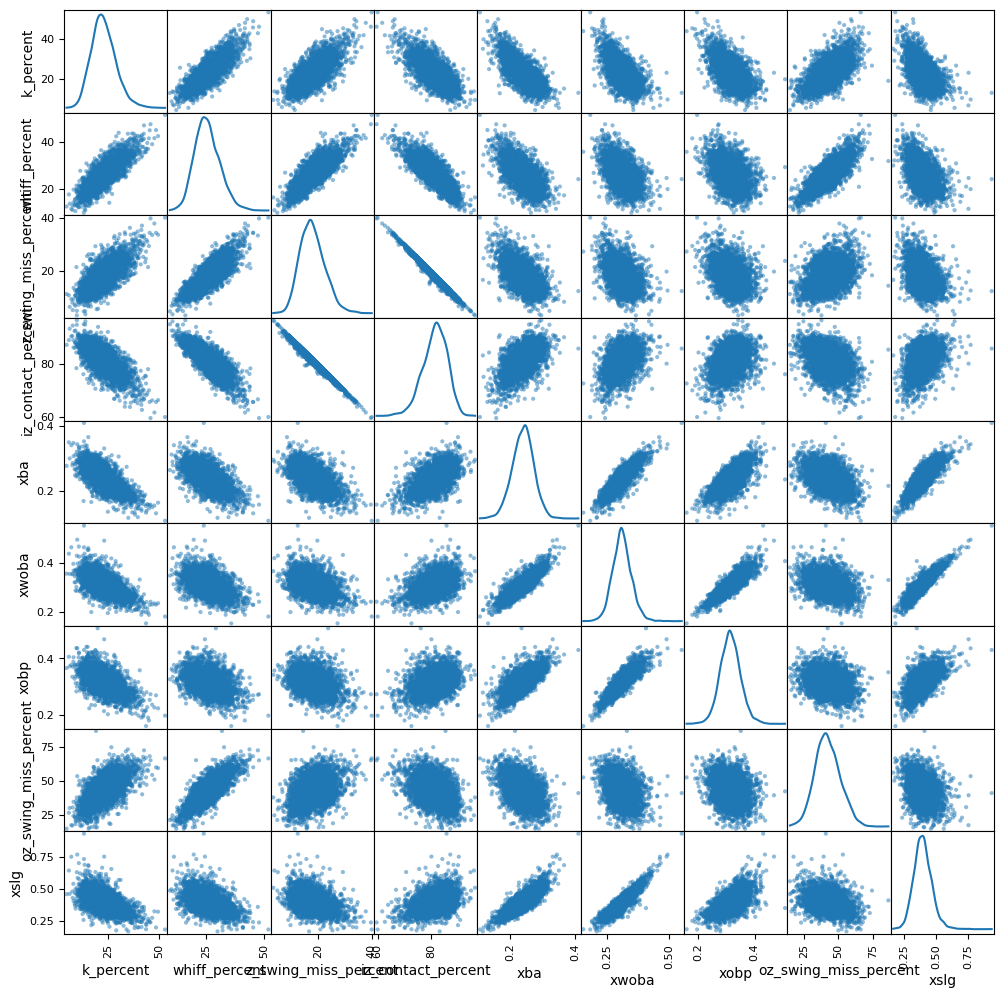

In [10]:
plot_top_x_corr(pitcher_combined, 10, "scatter", "Fpoints_IP")

Many strong correlations throughout, not as many as batting. Normally distributed. 

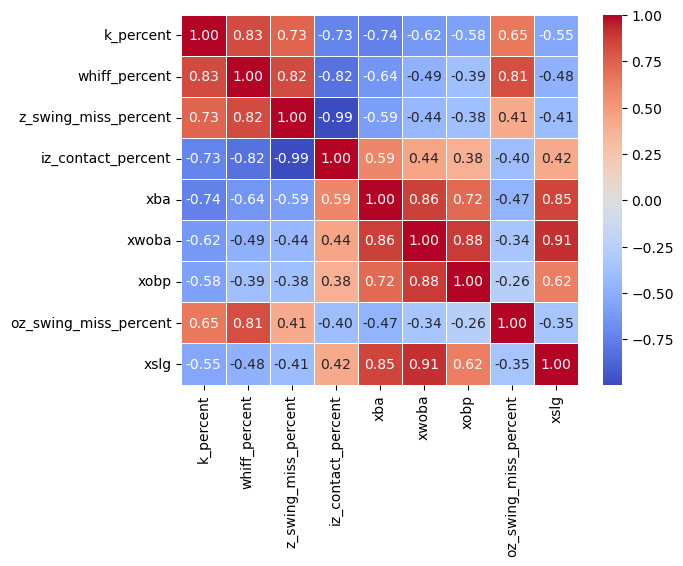

In [11]:
plot_top_x_corr(pitcher_combined, 10, "correlation", "Fpoints_IP")

In [12]:
# Adding columns that represents percentile of fpoints for the year. 
# Calculate the fantasy points from the previous year for each player
pitcher_combined['Fpoints_IP_prev_year'] = pitcher_combined.groupby('Name')['Fpoints_IP'].shift(1)

# Impute missing values in Fpoints_IP_prev_year using IterativeImputer
# Calculate the fantasy points from two previous years for each player
pitcher_combined['Fpoints_IP_two_prev_year'] = pitcher_combined.groupby('Name')['Fpoints_IP'].shift(2)

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
prev_imputer = IterativeImputer(max_iter = 30)
pitcher_combined[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']] = prev_imputer.fit_transform(pitcher_combined[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']])

# Calculate the weighted fantasy points for the last two years
pitcher_combined['Fpoints_IP_weighted'] = 0.7 * pitcher_combined['Fpoints_IP_prev_year'] + 0.3 * pitcher_combined['Fpoints_IP_two_prev_year']

fpoints2024 = pitcher_combined[pitcher_combined['year'] == 2024][["Name", "Fpoints_IP", "Fpoints_IP_prev_year", "Fpoints_IP_two_prev_year"]]

pitcher_combined['Fpoints_IP_percentile'] = pitcher_combined.groupby('year')['Fpoints_IP_prev_year'].rank(pct = True).drop(columns = ["Fpoints_IP_prev_year", "Fpoints_IP_two_prev_year", "Fpoints_IP_weighted"])
pitcher_combined["Fpoints_IP_percentile"].unique().size


2532

In [13]:
# K%-BB%
pitcher_combined['KpBB%'] = pitcher_combined['k_percent'] / pitcher_combined['bb_percent']

Some very strong positive and negative correlations here. Will need to be addressed in feature selection

## Train-test split

In [14]:
X = pitcher_combined.drop(columns = ['Fpoints_IP'])
y = pitcher_combined['Fpoints_IP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


na_ratio = X_train.isna().any(axis=1).mean()
print(f"Ratio of rows with NAs: {na_ratio:.2%}")

na_columns = X_train.columns[X_train.isna().any()].tolist()
print(f"Columns with NAs: {na_columns}")

X_train.head()

Ratio of rows with NAs: 13.11%
Columns with NAs: ['n_breaking_formatted', 'breaking_avg_speed', 'breaking_avg_spin', 'breaking_avg_break_x', 'breaking_avg_break_z', 'breaking_avg_break_z_induced', 'breaking_avg_break', 'breaking_range_speed', 'n_offspeed_formatted', 'offspeed_avg_speed', 'offspeed_avg_spin', 'offspeed_avg_break_x', 'offspeed_avg_break_z', 'offspeed_avg_break_z_induced', 'offspeed_avg_break']


Name  year  age  k_percent  bb_percent    xba   xslg   woba  \
1972     Ryne Harper  2020   31       22.2         4.4  0.262  0.450  0.297   
3374  Brandon Hughes  2023   27       28.3         9.2  0.217  0.393  0.298   
2424        Tim Hill  2021   31       25.3         7.6  0.238  0.371  0.316   
433     Matt Belisle  2017   37       17.2         3.8  0.276  0.391  0.259   
816     Carlos Rodon  2017   24       23.5         7.6  0.246  0.380  0.328   

      xwoba   xobp  ...  offspeed_avg_spin  offspeed_avg_break_x  \
1972  0.318  0.299  ...             1076.0                  -0.4   
3374  0.305  0.308  ...             1964.0                  17.4   
2424  0.302  0.316  ...                NaN                   NaN   
433   0.298  0.309  ...             1728.0                  -6.7   
816   0.303  0.311  ...             1610.0                  15.9   

      offspeed_avg_break_z  offspeed_avg_break_z_induced  offspeed_avg_break  \
1972                 -43.1                           3.5                 4.2   
3374                 -30.7                           6.8                18.8   
2424                   NaN                           NaN                 NaN   
433                  -30.7                           5.2                 9.1   
816                  -36.3                           3.1                16.6   

      Fpoints_IP_prev_year  Fpoints_IP_two_prev_year  Fpoints_IP_weighted  \
1972              1.763778                  1.805834             1.776395   
3374              1.763778                  1.805834             1.776395   
2424              1.833333                  2.056122             1.900170   
433               2.217391                  1.949949             2.137159   
816               1.727273                  1.794236             1.747362   

      Fpoints_IP_percentile     KpBB%  
1972               0.504237  5.045455  
3374               0.438998  3.076087  
2424               0.567460  3.328947  
433                0.863636  4.526316  
816                0.377273  3.092105  

[5 rows x 67 columns]

NA values are only present in breaking balls / offspeed. Since not every pitcher throws them. Will impute these based on other characteristics

In [15]:


# List of columns to drop
columns_to_drop = ['Name']

# Use SimpleImputer instead of IterativeImputer
first_preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('impute', SimpleImputer(strategy='mean'), na_columns),
        ('passthrough_feats', 'passthrough', X_train.columns.drop(columns_to_drop).drop(na_columns))
    ]
)

# Create a pipeline with the updated preprocessor
first_pipeline = Pipeline(steps=[('preprocessor', first_preprocessor)])


# Fit the pipeline on the training data and transform both training and test data
X_train_transformed = first_pipeline.fit_transform(X_train)
X_test_transformed = first_pipeline.transform(X_test)

transformed_features = first_preprocessor.get_feature_names_out()


first_transformed_features = [col.split('__')[-1] for col in transformed_features]
X_train_transformed = pd.DataFrame(X_train_transformed, columns=first_transformed_features, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=first_transformed_features, index=X_test.index)

X_train_transformed.head()


n_breaking_formatted  breaking_avg_speed  breaking_avg_spin  \
1972                  60.3                74.1             2333.0   
3374                  45.7                82.9             2372.0   
2424                  10.1                80.3             2031.0   
433                   42.1                84.0             2161.0   
816                   25.5                87.2             2315.0   

      breaking_avg_break_x  breaking_avg_break_z  \
1972                  12.9                 -59.0   
3374                  -3.8                 -36.5   
2424                   0.5                 -38.7   
433                    5.9                 -37.9   
816                   -6.3                 -33.8   

      breaking_avg_break_z_induced  breaking_avg_break  breaking_range_speed  \
1972                          -8.0                15.4                   3.2   
3374                           3.2                 5.7                   1.4   
2424                           4.2                 4.7                   1.6   
433                            1.9                 9.3                   5.5   
816                            2.7                 8.4                   2.8   

      n_offspeed_formatted  offspeed_avg_speed  ...  fastball_avg_spin  \
1972              0.900000           76.100000  ...             1821.0   
3374              1.200000           85.300000  ...             2306.0   
2424             13.489956           85.445515  ...             2153.0   
433               0.900000           88.100000  ...             2073.0   
816              10.500000           84.100000  ...             2178.0   

      fastball_avg_break_x  fastball_avg_break_z  \
1972                   0.3                 -24.8   
3374                  13.3                 -17.2   
2424                  17.7                 -33.4   
433                   -6.6                 -18.0   
816                   12.0                 -18.9   

      fastball_avg_break_z_induced  fastball_avg_break  Fpoints_IP_prev_year  \
1972                           9.2                 9.4              1.763778   
3374                          14.4                19.7              1.763778   
2424                           0.4                18.3              1.833333   
433                           15.2                16.9              2.217391   
816                           12.6                18.1              1.727273   

      Fpoints_IP_two_prev_year  Fpoints_IP_weighted  Fpoints_IP_percentile  \
1972                  1.805834             1.776395               0.504237   
3374                  1.805834             1.776395               0.438998   
2424                  2.056122             1.900170               0.567460   
433                   1.949949             2.137159               0.863636   
816                   1.794236             1.747362               0.377273   

         KpBB%  
1972  5.045455  
3374  3.076087  
2424  3.328947  
433   4.526316  
816   3.092105  

[5 rows x 66 columns]

## Feature Engineering

In [16]:
def calculate_yearly_averages(df, year_col='year'):
    # Group by year, then calculate the mean for each group
    yearly_averages = df.groupby(year_col).mean().reset_index()
    # Rename columns to indicate they are yearly averages
    yearly_averages.columns = [f"{col}_yearly_avg" if col != year_col else col for col in yearly_averages.columns]
    
    return yearly_averages

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages = calculate_yearly_averages(X_train_transformed)
yearly_averages.head()
# Merge the yearly averages with the training data
X_train_transformed_with_averages = X_train_transformed.merge(yearly_averages, on='year', how='left')

# Merge the yearly averages with the test data
X_test_transformed_with_averages = X_test_transformed.merge(yearly_averages, on='year', how='left')

# Drop year column as we dont need it anymore
X_train_transformed_with_averages = X_train_transformed_with_averages.drop(columns='year')
X_test_transformed_with_averages = X_test_transformed_with_averages.drop(columns='year')

X_train_transformed_with_averages.head()

n_breaking_formatted  breaking_avg_speed  breaking_avg_spin  \
0                  60.3                74.1             2333.0   
1                  45.7                82.9             2372.0   
2                  10.1                80.3             2031.0   
3                  42.1                84.0             2161.0   
4                  25.5                87.2             2315.0   

   breaking_avg_break_x  breaking_avg_break_z  breaking_avg_break_z_induced  \
0                  12.9                 -59.0                          -8.0   
1                  -3.8                 -36.5                           3.2   
2                   0.5                 -38.7                           4.2   
3                   5.9                 -37.9                           1.9   
4                  -6.3                 -33.8                           2.7   

   breaking_avg_break  breaking_range_speed  n_offspeed_formatted  \
0                15.4                   3.2              0.900000   
1                 5.7                   1.4              1.200000   
2                 4.7                   1.6             13.489956   
3                 9.3                   5.5              0.900000   
4                 8.4                   2.8             10.500000   

   offspeed_avg_speed  ...  fastball_avg_spin_yearly_avg  \
0           76.100000  ...                   2260.847826   
1           85.300000  ...                   2258.220745   
2           85.445515  ...                   2276.641892   
3           88.100000  ...                   2233.222535   
4           84.100000  ...                   2233.222535   

   fastball_avg_break_x_yearly_avg  fastball_avg_break_z_yearly_avg  \
0                        -4.141304                       -19.267029   
1                        -3.800798                       -18.436170   
2                        -3.480405                       -18.860135   
3                        -2.974648                       -19.075211   
4                        -2.974648                       -19.075211   

   fastball_avg_break_z_induced_yearly_avg  fastball_avg_break_yearly_avg  \
0                                12.831884                      16.900725   
1                                12.970745                      17.328191   
2                                13.073311                      17.117230   
3                                13.211549                      17.483380   
4                                13.211549                      17.483380   

   Fpoints_IP_prev_year_yearly_avg  Fpoints_IP_two_prev_year_yearly_avg  \
0                         1.735739                             1.820436   
1                         1.816914                             1.811949   
2                         1.797286                             1.780846   
3                         1.722167                             1.792614   
4                         1.722167                             1.792614   

   Fpoints_IP_weighted_yearly_avg  Fpoints_IP_percentile_yearly_avg  \
0                        1.761148                          0.501264   
1                        1.815425                          0.495779   
2                        1.792354                          0.489172   
3                        1.743301                          0.500455   
4                        1.743301                          0.500455   

   KpBB%_yearly_avg  
0          3.216852  
1          3.159821  
2          3.208416  
3          2.956698  
4          2.956698  

[5 rows x 130 columns]

## Data is normally distributed (ish) so no need for square/log/root transformations. Sticking to basic operators. 

In [17]:
# import itertools
# import operator
# import numpy as np
# import warnings

# warnings.filterwarnings('ignore')

# # List of non-yearly average features
# def generate_feature_combinations(*datasets):

#     # Assuming all datasets have the same columns
#     combined_dataset = datasets[0].copy()

#     # List of non-yearly average features
#     non_yearly_avg_features = [col for col in combined_dataset.columns if 'yearly_avg' not in col]

#     # List of operations and their symbols
#     operations = ['+', '-', '*']

#     # Generate all combinations of operations for the features
#     combinations = list(itertools.combinations(non_yearly_avg_features, 2))

#     # Apply the operations to the features
#     for symbol in operations:
#         for (feature1, feature2) in combinations:
#             if feature1 != feature2:
#                 new_feature_name = f"{feature1}_{symbol}_{feature2}"
#                 if symbol == '+':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] + dataset[feature2]
#                 elif symbol == '-':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] - dataset[feature2]
#                 elif symbol == '*':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] * dataset[feature2]

#     return datasets

# # Example usage
# X_train_transformed_with_averages, X_test_transformed_with_averages = generate_feature_combinations(X_train_transformed_with_averages, X_test_transformed_with_averages)
# X_train_transformed_with_averages.head()

In [18]:
X_test_transformed_with_averages = X_test_transformed_with_averages.reindex(columns=X_train_transformed_with_averages.columns, fill_value=0)
X_test_transformed_with_averages.head()

n_breaking_formatted  breaking_avg_speed  breaking_avg_spin  \
0                  22.3                88.0             1741.0   
1                  32.0                91.1             2586.0   
2                  24.7                86.5             2229.0   
3                  53.4                88.3             2727.0   
4                  15.2                84.4             2027.0   

   breaking_avg_break_x  breaking_avg_break_z  breaking_avg_break_z_induced  \
0                   1.9                 -29.9                           5.9   
1                   7.9                 -31.4                           1.4   
2                   3.3                 -36.4                           0.7   
3                   5.8                 -32.2                           2.7   
4                   0.7                 -31.2                           7.1   

   breaking_avg_break  breaking_range_speed  n_offspeed_formatted  \
0                 6.5                   1.5             14.900000   
1                 8.8                   1.7             13.489956   
2                 4.3                   2.5             11.400000   
3                 6.7                   1.6              6.500000   
4                 7.9                   1.7             27.900000   

   offspeed_avg_speed  ...  fastball_avg_spin_yearly_avg  \
0           86.700000  ...                   2236.130919   
1           85.445515  ...                   2258.759563   
2           84.700000  ...                   2236.130919   
3           87.600000  ...                   2276.641892   
4           84.700000  ...                   2241.817935   

   fastball_avg_break_x_yearly_avg  fastball_avg_break_z_yearly_avg  \
0                        -3.584123                       -19.337604   
1                        -3.344809                       -18.976230   
2                        -3.584123                       -19.337604   
3                        -3.480405                       -18.860135   
4                        -3.566033                       -18.483696   

   fastball_avg_break_z_induced_yearly_avg  fastball_avg_break_yearly_avg  \
0                                12.907521                      17.015599   
1                                12.364481                      17.018579   
2                                12.907521                      17.015599   
3                                13.073311                      17.117230   
4                                13.085598                      17.281793   

   Fpoints_IP_prev_year_yearly_avg  Fpoints_IP_two_prev_year_yearly_avg  \
0                         1.738950                             1.776473   
1                         1.787458                             1.885692   
2                         1.738950                             1.776473   
3                         1.797286                             1.780846   
4                         1.784746                             1.804467   

   Fpoints_IP_weighted_yearly_avg  Fpoints_IP_percentile_yearly_avg  \
0                        1.750207                          0.491181   
1                        1.816928                          0.510938   
2                        1.750207                          0.491181   
3                        1.792354                          0.489172   
4                        1.790663                          0.507393   

   KpBB%_yearly_avg  
0          2.941850  
1          2.957038  
2          2.941850  
3          3.208416  
4          2.995991  

[5 rows x 130 columns]

In [19]:

numeric_cols = X_train_transformed_with_averages.columns.tolist()

# Update the preprocessor to scale numeric features
preprocessor = ColumnTransformer(
	transformers=[
		('scale', StandardScaler(), numeric_cols)
	]
)

# Update the pipeline with the updated preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on the training data and transform both training and test data
X_train_preprocessed = pipeline.fit_transform(X_train_transformed_with_averages)
X_test_preprocessed = pipeline.transform(X_test_transformed_with_averages)

# Convert the preprocessed data back to a DataFrame
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train_transformed_with_averages.columns, index=X_train_transformed_with_averages.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test_transformed_with_averages.columns, index=X_test_transformed_with_averages.index)
X_train_preprocessed.shape

(3074, 130)

In [20]:
# from sklearn.feature_selection import SelectKBest, f_regression

# # Select the top 100 features
# selector = SelectKBest(score_func=f_regression, k=100)
# X_train_reduced = selector.fit_transform(X_train_preprocessed, y_train)
# X_test_reduced = selector.transform(X_test_preprocessed)

# # Get the selected feature names
# selected_features = X_train_preprocessed.columns[selector.get_support()]

# # Convert the reduced datasets back to DataFrames
# X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_features, index=X_train_preprocessed.index)
# X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_features, index=X_test_preprocessed.index)

# X_train_reduced.head()

In [21]:


warnings.filterwarnings('ignore')



    # Update classifier_params with XGBoost and LightGBM hyperparameters
def tune_and_select_model(X_train, y_train, X_test, y_test):
    # Define feature selectors
    # feature_selectors = {
    #     'pca' : PCA(),
    #     'select_k_best': SelectKBest(score_func=f_regression, k=10),
    #     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
    # }

    # Define regressors
    regressors = {
        'linear_regression': Lasso(),
        'random_forest': RandomForestRegressor(),
        'gradient_boosting': GradientBoostingRegressor(),
        'svm': SVR(),
        'neural_network': MLPRegressor()
    }

    # Define hyperparameters for feature selectors
    # feature_selector_params = {
    #     'pca__n_components': [10, 25, 50],
    #     'select_k_best__k': [10, 25, 50],
    #     'select_from_model__max_features': [10, 25, 50]
    # }

    # Define hyperparameters for regressors
    regressor_params = {
        'linear_regression__alpha': np.logspace(-4, 2, 50),
        'random_forest__n_estimators': [25, 50, 100, 200],
        'random_forest__max_depth': [2,4,6,10,14,18,25,40],
        'gradient_boosting__n_estimators': [50, 100, 200],
        'svm__C': [0.01, 0.1, 1, 10],
        'neural_network__hidden_layer_sizes': [(50,), (100,), (50, 50)]
    }

    # Create a list to store the results
    results = []

    # Iterate over feature selectors and regressors

    # Add XGBoost and LightGBM to regressors
    regressors.update({
        'xgboost': xgb.XGBRegressor(),
        'lightgbm': lgb.LGBMRegressor(verbose = -1)
    })

    # Update regressor_params with XGBoost and LightGBM hyperparameters
    regressor_params.update({
        'xgboost__n_estimators': [25,50, 100, 200],
        'xgboost__learning_rate': [0.001,0.01, 0.1, 0.2],
        'lightgbm__n_estimators': [25,50, 100, 200],
        'lightgbm__learning_rate': [0.001,0.01, 0.1, 0.2]
    })

    # for fs_name, fs in feature_selectors.items():
    for reg_name, reg in regressors.items():
        # Create a pipeline
        pipeline = Pipeline([
            # (fs_name, fs),
            (reg_name, reg)
        ])

        # Combine hyperparameters
        # params = {**{f'{k}': v for k, v in feature_selector_params.items() if k.startswith(fs_name)},
                    # **{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}

        params = {**{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}
        
        print(f' Searching {params}')

        # Perform RandomizedSearchCV
        search = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=5, cv=3, random_state=42)
        print("Search complete")
        search.fit(X_train, y_train)
        print("Fit complete")

        # Get the best model
        best_model = search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        print("results calculated")

        # Store the results
        results.append({
            # 'feature_selector': fs_name,
            'regressor': reg_name,
            'best_params': search.best_params_,
            'mse': mse,
            'rmse': rmse
        })

    # Find the best result
    best_result = min(results, key=lambda x: x['rmse'])

    return best_result, results



# Example usage
# best_result, all_results = tune_and_select_model(X_train_preprocessed, y_train, X_test_preprocessed, y_test)
# print("Best Result:", best_result)
# print("All Results:", all_results)

In [22]:

# with open('models/pitcher_model_feb16_best.pkl', 'wb') as f:
#     pickle.dump(best_result, f)

In [23]:
## MSE with all sum/diff/multiplication features: 0.448
## MSE without: 0.446
## MSE without feature selection at all + previous percentile: 0.2
## MSE with adding fangraphs: 0.507
## Final MSE: 0.446

with open('models/pitcher_model_feb16_best.pkl', 'rb') as f:
    loaded_best_result = pickle.load(f)

loaded_best_result

{'regressor': 'linear_regression',
 'best_params': {'linear_regression__alpha': np.float64(0.012067926406393288)},
 'mse': 0.4467822038589176,
 'rmse': np.float64(0.6684176866742214)}

In [24]:

# Extract the best feature selector, regressor, and parameters
# best_feature_selector_name = loaded_best_result['feature_selector']
best_regressor_name = loaded_best_result['regressor']
best_params = loaded_best_result['best_params']

# Define feature selectors
# feature_selectors = {
#     'pca': PCA(),
#     'select_k_best': SelectKBest(score_func=f_regression),
#     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
# }

# Define regressors
regressors = {
    'linear_regression': Lasso(),
    'random_forest': RandomForestRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'svm': SVR(),
    'neural_network': MLPRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgb.LGBMRegressor()
}

# Create the pipeline with the best feature selector and regressor
best_model = Pipeline([
    # (best_feature_selector_name, feature_selectors[best_feature_selector_name]),
    (best_regressor_name, regressors[best_regressor_name])
])

# Set the best parameters
best_model.set_params(**best_params)
best_model.fit(X_train_preprocessed, y_train)




Pipeline(steps=[('linear_regression',
                 Lasso(alpha=np.float64(0.012067926406393288)))])

In [25]:
# Extract the feature importances from the best model
if hasattr(best_model.named_steps[best_regressor_name], 'feature_importances_'):
    importances = best_model.named_steps[best_regressor_name].feature_importances_
elif hasattr(best_model.named_steps[best_regressor_name], 'coef_'):
    importances = best_model.named_steps[best_regressor_name].coef_
else:
    raise ValueError(f"The model {best_regressor_name} does not have feature importances or coefficients.")

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head(10)  # Display the top 10 features

Feature  Importance
16                 k_percent    0.143281
54        fastball_avg_speed    0.060041
43             whiff_percent    0.051201
64                     KpBB%    0.046999
36      z_swing_miss_percent    0.042774
61  Fpoints_IP_two_prev_year    0.042523
48          f_strike_percent    0.042179
6         breaking_avg_break    0.035291
55         fastball_avg_spin    0.022523
9         offspeed_avg_speed    0.018227

In [26]:


# Extract the gradient boosting model from the best_model pipeline
gradient_boosting_model = best_model.named_steps['linear_regression']

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed.values,
    feature_names=X_train_preprocessed.columns,
    class_names=['Fpoints_IP'],
    mode='regression'
)

# Select an instance to explain
instance_idx = 90
instance = X_test_preprocessed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)
# Get the name corresponding to the instance being explained
instance_name = X_test.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation
explanation.show_in_notebook(show_table=True)

Explaining prediction for: Jared Hughes


In [27]:
# all_results = pd.DataFrame(all_results).sort_values(by = 'mse')
# all_results

## TODO: try and get players who did not pitch in 2024.

In [ ]:
razz_preds = pd.read_csv("data/razzball_pitch_preds.csv")
razz_preds['Name'] = razz_preds['Name'].apply(unidecode.unidecode)
names_2025 = razz_preds['Name'].unique()
razz_preds.head()
print(razz_preds.columns)

Index(['#', 'Name', 'Team', 'POS', 'R/L', 'G', 'GS', 'QS', 'TBF', 'IP', 'W',
       'L', 'SV', 'HLD', 'ERA', 'SIERA', 'WHIP', 'K', 'BB', 'H', 'HBP', 'ER',
       'R', 'HR', 'GB%', 'FB%', 'LD%', 'BABIP', 'RazzID'],
      dtype='object')


In [29]:
print(all_fpoints_24.shape)

(630, 2)


In [30]:
# Find names in names_2025 that aren't in all_fpoints_24['Name']
missing_names = [name for name in names_2025 if name not in all_fpoints_24['Name'].values]
missing_names

['Sandy Alcantara',
 'Shane McClanahan',
 'German Marquez',
 'Kodai Senga',
 'Luis L. Ortiz',
 'Tomoyuki Sugano',
 'Nestor Cortes',
 'Brandon Woodruff',
 'Roki Sasaki',
 'Shohei Ohtani',
 'Johan Oviedo',
 'Lucas Giolito',
 'Tony Gonsolin',
 'Cade Cavalli',
 'Kyle Wright',
 'Jacob deGrom',
 'Bubba Chandler',
 'Ian Anderson',
 'Dustin May',
 'Shane Bieber',
 'Anthony DeSclafani',
 'Spencer Strider',
 'Jackson Jobe',
 'Lance McCullers Jr.',
 'Kyle Hart',
 'Quinn Mathews',
 'Eury Perez',
 'Mike Burrows',
 'Andrew Painter',
 'AJ Smith-Shawver',
 'Shane Smith',
 'Jacob Misiorowski',
 'Chase Dollander',
 'Gunnar Hoglund',
 'Sawyer Gipson-Long',
 'Michael Fulmer',
 'Seth Halvorsen',
 'JT Brubaker',
 'Jake Bloss',
 'Tyler Stuart',
 'Jonathan Bowlan',
 'Gordon Graceffo',
 'Jackson Rutledge',
 'Nick Hernandez',
 'Phil Maton',
 'Luis Peralta',
 'Rolddy Munoz',
 'Liam Hendriks',
 'Angel Perdomo',
 'Felix Bautista',
 'Scott Effross',
 'Mason Thompson',
 'Casey Legumina',
 'Sean Reynolds',
 "Riley O'

In [31]:
pitch_mets = pd.read_csv("data/pitcher_metrics.csv")
pitch_mets= pitch_mets.rename(columns={"last_name, first_name": "Name"})
name_split = pitch_mets['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
pitch_mets['Name'] = name_split[1] + ' ' + name_split[0]
pitch_mets['Name'] = pitch_mets['Name'].apply(unidecode.unidecode)
pitch_mets.head()

Name  player_id  year  k_percent  bb_percent    xba   xslg  \
0   Bartolo Colon     112526  2015       16.7         2.9  0.268  0.427   
1  LaTroy Hawkins     115629  2015       21.0         4.3  0.247  0.380   
2      Randy Wolf     150116  2015       17.4         9.3  0.304  0.481   
3   Jason Marquis     150302  2015       17.1         6.5  0.259  0.381   
4    A.J. Burnett     150359  2015       20.5         7.0  0.261  0.406   

    woba  xwoba   xobp  ...  breaking_avg_break_z_induced  breaking_avg_break  \
0  0.316  0.314  0.294  ...                           3.3                 6.5   
1  0.316  0.289  0.281  ...                           6.7                 8.4   
2  0.387  0.376  0.375  ...                          -2.0                10.7   
3  0.387  0.309  0.317  ...                           5.8                 6.8   
4  0.315  0.323  0.326  ...                          -9.0                12.8   

   breaking_range_speed  n_offspeed_formatted  offspeed_avg_speed  \
0                   1.8                   7.4                82.6   
1                   2.3                   8.0                84.7   
2                   7.3                  11.1                78.5   
3                   1.5                  21.2                78.8   
4                   1.5                   8.8                86.3   

   offspeed_avg_spin  offspeed_avg_break_x  offspeed_avg_break_z  \
0             1727.0                 -13.2                 -32.0   
1             1698.0                 -12.1                 -28.7   
2             1669.0                  13.1                 -34.5   
3             1239.0                 -10.3                 -41.8   
4             1678.0                 -10.8                 -33.4   

   offspeed_avg_break_z_induced  offspeed_avg_break  
0                           9.0                16.4  
1                          10.0                16.0  
2                          10.2                16.8  
3                           3.0                11.7  
4                           3.7                12.0  

[5 rows x 63 columns]

In [32]:
# Iterate through names in names_2025
for name in names_2025:
    print(name)
    if name not in all_fpoints_24['Name'].values:
        # Get the most recent data from pitcher_fpoints for the name
        recent_data = pitcher_fpoints[pitcher_fpoints['Name'] == name].sort_values(by='year', ascending=False).head(1).copy()
        recent_data.loc[:, 'year'] = 2024

        recent_metrics = pitch_mets[pitch_mets['Name'] == name].sort_values(by='year', ascending=False).head(1).copy()
        recent_metrics.loc[:, 'year'] = 2024

        print(recent_data)
        
        # Check if there is any data for the name
        if not recent_data.empty:
            # Append the most recent data to all_fpoints_24
            all_fpoints_24 = pd.concat([all_fpoints_24, recent_data[['Name', 'Fpoints_IP']]], ignore_index=True)
            pitch_mets = pd.concat([pitch_mets, recent_metrics], ignore_index=True)

all_fpoints_24

Zack Wheeler
Seth Lugo
Logan Webb
Framber Valdez
Logan Gilbert
Jose Berrios
Aaron Nola
Jameson Taillon
Tyler Anderson
Luis Castillo
Pablo Lopez
Bailey Ober
Cole Ragans
Corbin Burnes
George Kirby
Bryce Miller
Michael Wacha
Erick Fedde
Dylan Cease
Mitch Keller
Jake Irvin
Ronel Blanco
Ranger Suarez
Justin Steele
Brady Singer
Tanner Bibee
JP Sears
Tarik Skubal
Chris Bassitt
Luis Severino
Austin Gomber
Max Fried
Freddy Peralta
Cristopher Sanchez
Hunter Greene
Bowden Francis
Grayson Rodriguez
Hunter Brown
Kevin Gausman
Tanner Houck
Joe Ryan
Spencer Schwellenbach
Sean Manaea
Reynaldo Lopez
Miles Mikolas
Ryan Feltner
Taj Bradley
Gerrit Cole
Michael King
Shota Imanaga
Brandon Pfaadt
Paul Skenes
Nathan Eovaldi
Zac Gallen
Zach Eflin
Yusei Kikuchi
Sandy Alcantara
                 Name  year  age     IP    H    K  BB  ER  S  W   L  Hold  \
5086  Sandy Alcantara  2024   27  184.2  176  151  48  85  0  7  12     0   

      Fpoints  Fpoints_IP  
5086    309.6    1.680782  
Andrew Abbott
Jared Jones
M

Name  Fpoints_IP
0    Justin Verlander    1.213097
1       Kenley Jansen    2.335793
2        Jesse Chavez    1.922345
3      Charlie Morton    1.752271
4        Max Scherzer    1.886311
..                ...         ...
722     Dylan Coleman    0.127072
723   Elvin Rodriguez   -0.493151
724     Alan Busenitz    0.250996
725       Josiah Gray    1.572327
726    Jhonathan Diaz    1.543046

[727 rows x 2 columns]

In [33]:

fpoints2024 = fpoints2024.merge(all_fpoints_24, on = ["Name", "Fpoints_IP"], how = "outer")
all_fpoints_24[all_fpoints_24["Name"] == "Kodai Senga"]

Name  Fpoints_IP
633  Kodai Senga    2.331728

In [34]:
pitch_mets[pitch_mets["Name"] == "Sandy Alcantara"]

Name  player_id  year  k_percent  bb_percent    xba   xslg  \
2349  Sandy Alcantara     645261  2018       20.5        15.8  0.215  0.327   
2920  Sandy Alcantara     645261  2019       18.0         9.7  0.244  0.424   
3379  Sandy Alcantara     645261  2020       22.7         8.7  0.243  0.386   
3929  Sandy Alcantara     645261  2021       24.0         6.0  0.232  0.368   
4500  Sandy Alcantara     645261  2022       23.4         5.6  0.215  0.331   
5086  Sandy Alcantara     645261  2023       19.8         6.3  0.265  0.417   
6062  Sandy Alcantara     645261  2024       19.8         6.3  0.265  0.417   

       woba  xwoba   xobp  ...  breaking_avg_break_z_induced  \
2349  0.317  0.310  0.348  ...                           0.9   
2920  0.308  0.322  0.325  ...                          -0.4   
3379  0.288  0.310  0.314  ...                           0.7   
3929  0.279  0.288  0.287  ...                           2.7   
4500  0.260  0.266  0.267  ...                           3.3   
5086  0.301  0.320  0.317  ...                           3.3   
6062  0.301  0.320  0.317  ...                           3.3   

      breaking_avg_break  breaking_range_speed  n_offspeed_formatted  \
2349                 6.0                   2.5                  12.7   
2920                 6.1                   2.7                  12.1   
3379                 5.2                   3.2                  10.3   
3929                 4.8                   2.8                  23.6   
4500                 4.2                   1.8                  27.6   
5086                 4.8                   2.2                  27.3   
6062                 4.8                   2.2                  27.3   

      offspeed_avg_speed  offspeed_avg_spin  offspeed_avg_break_x  \
2349                89.0             1783.0                 -14.7   
2920                89.1             1923.0                 -16.1   
3379                90.1             1983.0                 -16.4   
3929                91.8             2006.0                 -16.1   
4500                91.8             2056.0                 -16.8   
5086                91.1             1968.0                 -16.3   
6062                91.1             1968.0                 -16.3   

      offspeed_avg_break_z  offspeed_avg_break_z_induced  offspeed_avg_break  
2349                 -30.6                           4.4                15.5  
2920                 -30.5                           4.7                17.0  
3379                 -29.7                           4.1                17.0  
3929                 -29.2                           3.3                16.5  
4500                 -28.9                           3.7                17.3  
5086                 -29.3                           3.7                16.9  
6062                 -29.3                           3.7                16.9  

[7 rows x 63 columns]

In [35]:
## Prediciting for 2025
pitch_mets_2024 = pitch_mets[pitch_mets['year'] == 2024]

pitch_mets_2024["KpBB%"] = pitch_mets_2024["k_percent"] - pitch_mets_2024["bb_percent"]



pitch_2024 = pitch_mets_2024.merge(fpoints2024, on="Name")



pitch_2024[pitch_2024["Name"] == "Kodai Senga"]


Name  player_id  year  k_percent  bb_percent    xba   xslg   woba  \
637  Kodai Senga     673540  2024       29.1        11.1  0.225  0.365  0.282   

     xwoba   xobp  ...  offspeed_avg_speed  offspeed_avg_spin  \
637  0.304  0.316  ...                83.2             1118.0   

     offspeed_avg_break_x  offspeed_avg_break_z  offspeed_avg_break_z_induced  \
637                  -7.2                 -37.7                           1.9   

     offspeed_avg_break  KpBB%  Fpoints_IP  Fpoints_IP_prev_year  \
637                 8.7   18.0    2.331728                   NaN   

     Fpoints_IP_two_prev_year  
637                       NaN  

[1 rows x 67 columns]

In [36]:


print(pitch_2024['Fpoints_IP_prev_year'].isna().sum())
print(pitch_2024['Fpoints_IP_two_prev_year'].isna().sum())

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
pitch_2024[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']] = prev_imputer.transform(pitch_2024[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']])


# Calculate the weighted fantasy points for the last two years
pitch_2024['Fpoints_IP_weighted'] = 0.7 * pitch_2024['Fpoints_IP_prev_year'] + 0.3 * pitch_2024['Fpoints_IP_two_prev_year']

# Calculate the percentile of the weighted fantasy points for each year
pitch_2024['Fpoints_IP_percentile'] = pitch_2024.groupby('year')['Fpoints_IP_weighted'].rank(pct=True).drop(columns = ["Fpoints_IP_prev_year", "Fpoints_IP_two_prev_year", "Fpoints_IP_weighted"])

pitch_2024['Fpoints_IP_prev_year'].unique().size
pitch_2024.head()

284
284


Name  player_id  year  k_percent  bb_percent    xba   xslg  \
0  Justin Verlander     434378  2024       18.7         6.8  0.234  0.389   
1     Kenley Jansen     445276  2024       28.4         9.2  0.208  0.352   
2      Jesse Chavez     445926  2024       20.8         7.2  0.263  0.411   
3    Charlie Morton     450203  2024       23.8         9.3  0.243  0.402   
4      Max Scherzer     453286  2024       22.6         5.6  0.243  0.399   

    woba  xwoba   xobp  ...  offspeed_avg_break_x  offspeed_avg_break_z  \
0  0.337  0.301  0.297  ...                 -13.4                 -29.2   
1  0.253  0.280  0.285  ...                   NaN                   NaN   
2  0.315  0.318  0.318  ...                 -16.0                 -35.5   
3  0.335  0.326  0.333  ...                 -17.2                 -37.8   
4  0.312  0.304  0.291  ...                 -13.7                 -39.0   

   offspeed_avg_break_z_induced  offspeed_avg_break  KpBB%  Fpoints_IP  \
0                           9.7                16.8   11.9    1.213097   
1                           NaN                 NaN   19.2    2.335793   
2                           2.2                16.3   13.6    1.922345   
3                           0.2                17.3   14.5    1.752271   
4                           1.0                14.0   17.0    1.886311   

   Fpoints_IP_prev_year  Fpoints_IP_two_prev_year  Fpoints_IP_weighted  \
0              2.037631                  2.968610             2.316925   
1              2.072398                  2.531250             2.210054   
2              2.678363                  1.914616             2.449239   
3              1.884120                  1.994186             1.917140   
4              2.178712                  2.772571             2.356870   

   Fpoints_IP_percentile  
0               0.923393  
1               0.894665  
2               0.950752  
3               0.785226  
4               0.935705  

[5 rows x 69 columns]

In [37]:
age_2024 = pd.read_csv("data/pitcher_2024_age.csv")

age_2024 = age_2024.rename(columns = {"last_name, first_name":"Name", "player_age":"age"})

name_split = age_2024['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
age_2024['Name'] = name_split[1] + ' ' + name_split[0]

age_2024['Name'] = age_2024['Name'].apply(unidecode.unidecode)

pitch_mets_2024_new = pitch_2024.merge(age_2024, on = ["Name", 'year', 'player_id'], how = 'left').drop(columns = ['player_id'])

pitch_mets_2024_new = pitch_mets_2024_new.fillna(30)





In [38]:
import warnings

warnings.filterwarnings('ignore')

# Imputation processing
new_preprocessed_first = first_pipeline.transform(pitch_mets_2024_new)
new_preprocessed_first = pd.DataFrame(new_preprocessed_first, columns=first_transformed_features, index=pitch_mets_2024_new.index)

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages_new = calculate_yearly_averages(new_preprocessed_first)

# Merge the yearly averages with the training data
yearly_new_prep = new_preprocessed_first.merge(yearly_averages_new, on='year', how='left')

# Drop year column as we dont need it anymore
yearly_new_prep = yearly_new_prep.drop(columns='year')

# print(yearly_new_prep["fastball_avg_break_z_induced"])


# Generate feature combinations

# Reindex to match the training data columns

# print(yearly_new_prep)
new_transformed = pipeline.transform(yearly_new_prep)
print(new_transformed.shape)
new_transformed = pd.DataFrame(new_transformed, columns=numeric_cols, index=yearly_new_prep.index)

# expected_columns = pd.Index(selector.get_feature_names_out())  # or use the columns from the fitting data

# new_selected = new_transformed.reindex(columns=expected_columns, fill_value=0)
# new_selected = pd.DataFrame(new_selected, columns=selected_features, index=new_transformed.index)
# 
# print(new_selected.isna().sum())
# Find the columns that are different between new_transformed and X_train_preprocessed
diff_columns = set(new_transformed.columns).difference(set(X_train_preprocessed.columns))
print(f"Columns in new_transformed but not in X_train_preprocessed: {diff_columns}")

new_preds = best_model.predict(new_transformed)








(731, 130)
Columns in new_transformed but not in X_train_preprocessed: set()


In [39]:
## Combining preds with data:
pitch_2024['proj_fpoints_ip'] = new_preds
pitch_2024[['Name', 'proj_fpoints_ip']].sort_values(by = 'proj_fpoints_ip', ascending = False).head(50)

Name  proj_fpoints_ip
660     Felix Bautista         3.567595
618       Mason Miller         3.567436
644       Jacob deGrom         3.466860
238     Devin Williams         3.464284
248        Griffin Jax         3.189869
670  Robert Stephenson         3.139532
197         Josh Hader         3.099925
649    Spencer Strider         3.086249
444        Edwin Uceta         3.082141
465      Dedniel Nunez         3.076233
505    Garrett Crochet         3.072181
333     Tony Santillan         3.041731
405   Jeremiah Estrada         3.013468
455         Cade Smith         2.966053
659      Angel Perdomo         2.950197
30          Chris Sale         2.930545
271       Jeff Hoffman         2.903631
13         Kirby Yates         2.892413
688         Matt Brash         2.889873
127        Blake Snell         2.882460
52     Aroldis Chapman         2.819190
415       Tarik Skubal         2.816425
55         Yimi Garcia         2.809187
599         Alek Jacob         2.809030
309        Jhoan Duran         2.794123
5         Chris Martin         2.785064
320         Kris Bubic         2.779452
17     David Robertson         2.765484
23       Fernando Cruz         2.743722
78          Jason Adam         2.741746
616        Paul Skenes         2.738444
507       Andrew Nardi         2.684871
299       Reed Garrett         2.683911
206    Raisel Iglesias         2.658246
253        Bryan Abreu         2.655480
485      Robert Garcia         2.654615
621        Troy Taylor         2.649549
410          Dylan Lee         2.630465
212           A.J. Puk         2.619015
408        Keegan Akin         2.617037
172         Edwin Diaz         2.614652
42          Sonny Gray         2.600200
200       Jimmy Herget         2.598904
548         Alex Vesia         2.594986
287       Tanner Scott         2.590402
225        Joe Jimenez         2.587169
302           Joe Ryan         2.585357
479      Jeff Criswell         2.575956
56        Zack Wheeler         2.568011
522    Justin Martinez         2.565991

In [40]:
# Get the index based on a name input
input_name = "Ryan Pepiot"
instance_idx = pitch_mets_2024_new[pitch_mets_2024_new['Name'] == input_name].index[0]
instance = new_transformed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)

# Get the name corresponding to the instance being explained
instance_name = pitch_mets_2024_new.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation
explanation.show_in_notebook(show_table=True)

Explaining prediction for: Ryan Pepiot


In [41]:
whole_df = pitch_2024.merge(razz_preds, on = "Name", how = "left")
whole_df['proj_fpoints_skill'] = whole_df['proj_fpoints_ip'] * whole_df['IP']
whole_df['proj_fpoints'] = whole_df['proj_fpoints_skill'] + 2*whole_df['W'] - 2*whole_df['L'] + 5*whole_df['SV'] + 2*whole_df["HLD"]
final_df=whole_df[["Name", "POS", "proj_fpoints_skill", "proj_fpoints"]].sort_values(by = "proj_fpoints", ascending = False)
final_df["rank"] = final_df["proj_fpoints"].rank(ascending = False)
final_df=final_df.set_index("rank")
final_df = final_df.rename(columns = {"POS":"Pos"})
final_df.head(50)

Name Pos  proj_fpoints_skill  proj_fpoints
rank                                                             
1.0            Zack Wheeler  SP          474.568383    485.968383
2.0            Tarik Skubal  SP          478.510607    485.110607
3.0              Chris Sale  SP          443.391526    455.391526
4.0             Paul Skenes  SP          447.735628    454.335628
5.0           Logan Gilbert  SP          447.723407    454.323407
6.0             Blake Snell  SP          443.898763    452.298763
7.0             Cole Ragans  SP          441.920680    449.320680
8.0         Garrett Crochet  SP          431.027050    436.227050
9.0                Joe Ryan  SP          430.203355    435.203355
10.0            Pablo Lopez  SP          426.716960    433.116960
11.0            Dylan Cease  SP          419.775612    428.175612
12.0            Bailey Ober  SP          421.844184    426.444184
13.0          Corbin Burnes  SP          416.023142    425.223142
14.0             Sonny Gray  SP          414.731964    421.731964
15.0           Michael King  SP          410.727744    417.327744
16.0          Hunter Greene  SP          408.565893    412.565893
17.0      Grayson Rodriguez  SP          402.855230    410.855230
18.0         Framber Valdez  SP          399.834247    410.634247
19.0           George Kirby  SP          402.871384    408.271384
20.0           Tanner Bibee  SP          405.079127    408.079127
21.0         Freddy Peralta  SP          402.291400    406.891400
22.0             Aaron Nola  SP          394.611313    403.011313
23.0  Spencer Schwellenbach  SP          390.045678    400.845678
24.0     Yoshinobu Yamamoto  SP          389.648292    399.248292
25.0          Luis Castillo  SP          394.135098    398.735098
26.0          Justin Steele  SP          389.828673    396.628673
27.0         Reynaldo Lopez  SP          382.536699    391.736699
28.0          Yusei Kikuchi  SP          383.583017    387.583017
29.0            Gerrit Cole  SP          379.061575    384.661575
30.0            Jared Jones  SP          382.813446    383.813446
31.0         Brandon Pfaadt  SP          375.814894    381.814894
32.0              Seth Lugo  SP          375.318885    380.518885
33.0           Bryce Miller  SP          376.943441    380.343441
34.0           Hunter Brown  SP          373.032099    380.032099
35.0           Jacob deGrom  SP          373.034150    378.434150
36.0            Taj Bradley  SP          375.529841    378.329841
37.0          Shota Imanaga  SP          369.421288    375.421288
38.0            Ryan Pepiot  SP          372.090245    373.290245
39.0         Nathan Eovaldi  SP          363.395393    369.195393
40.0              Max Fried  SP          359.665636    368.665636
41.0             Logan Webb  SP          360.001321    367.201321
42.0         Devin Williams  RP          207.510614    365.310614
43.0          Jack Flaherty  SP          364.201844    364.401844
44.0           Carlos Rodon  SP          356.550652    361.750652
45.0       Shane McClanahan  SP          357.266904    360.066904
46.0             Josh Hader  RP          200.875119    358.875119
47.0           Mitch Keller  SP          353.401315    354.001315
48.0           Ronel Blanco  SP          346.079501    351.079501
49.0       Brandon Woodruff  SP          345.061316    348.461316
50.0         MacKenzie Gore  SP          345.799201    346.799201

In [42]:
final_df.to_csv("predictions/initial_picher_preds.csv")